# Dueling Deep-Q Learning

Prereq: You now should have an understanding of [Double Deep-Q Learning](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Deep%20Reinforcement%20Learning/Double%20Deep-Q%20Learning/double_deep_q_learning.ipynb)!

But as a recap, the main purpose of the Double Deep-Q method was to help solve the overestimation bias that came with vanilla DQN. In your standard DQN, you would use our lagging copy $Q_{target}$ model to do both action evaluation (what is the value of different actions at a state) as well as action selection (taking the argmax for the highest valued action). The Double Deep-Q method proposed using our more up-to-date model $Q$ that isn't lagging and has the most recent knowledge to decide what action to take, but use the $Q_{target}$ to get the value for that specific action.

But there is another problem that we havent solved yet: *Not all states are equally valuable, regardless of the action you take!*

### Metaphor to Understand: Studying for an Exam

Let’s say you're enrolled in a few different classes — History, Math, Biology. These are your **states**. And for each class, you have a few ways to study: watching YouTube videos, reading the textbook, doing flashcards, or attending a study group. These are your **actions**.

Like for everyone, some classes are easier for you to do well in regardless of your study method. You could just be really good at math, so no matter the study method you pick, you end up doing well. This is a **HIGH VALUE** state, as the value of the state itself is a measure of the high reward you can get. 

On the other hand, you may not be good at History. Reading the textbook is boring, you don't like flashcards, and studying with others isn't really helpful. On the other hand, watching Youtube videos from that crazy historian is lots of fun and you end up learning the material anyway! Therefore, your History class is a low value state, but the action you take has a huge role in how you end up doing. 


This is known as the **ADVANTAGE**, which is how much better is action $a$ compared to all the other actions available at $s$. Before we get ahead of ourselves though, lets think all the way back to when we derived the Bellman Equation for [Policy Iteration](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Based%20Learning/intro_rl_and_policy_iter.ipynb)

### Recap: Bellman Equation, V(s), Q(s,a)

Here was our Bellman Equation that we derived!

$$\text{Bellman Equation: } V_\pi(s) = \sum_a \pi(a|s)\sum_{s'}\sum_{r}[r + \gamma V_{\pi}(s')]P(s',r|a,s)$$

And the Bellman Equation gave us the values of every single state $V(s)$, because we took an expected value (weighted average) over all the possible actions I could have taken at that State. 

If I dont take the expected value over all the actions, then we get our $Q(s,a)$ function, which is the value of taking a specific action at a specific state. 

$$\text{Q Function: } Q_\pi(s,a) = \sum_{s'}\sum_{r}[r + \gamma V_{\pi}(s')]P(s',r|a,s)$$

But notice, they are the same thing! The Bellman Equation averages over the actions so we get the overall value of a state, the Q function doesn't average over the actions so it is the value of a specific action at a state. And so the key result putting all this together is:

$$V_\pi(s) = \sum_a \pi(a|s)Q_\pi(s,a) $$

Our values $V$ are just a weighted average over the $Q$ values 

### Advantage Function

If our $Q$ function gives us the value of taking an action $a$ at state $s$, and the values $V(s)$ tells us the average value across all actions at state $s$, then we can write:

$$A(s,a) = Q(s,a) - V(s)$$

The advantage of taking an action $A(s,a)$ tells us how much better or worse taking an action $a$ is compared to the average performance of that state!
Our final neural network needs to predict $Q$, therefore we can rewrite this as:

$$Q(s,a) = V(s) + A(s,a) $$

Our $Q$ values can be decomposed into the sum of the Value of a state (averaged over all actions) and the advantage of taking a specific action. This is the setup for our Dueling Deep-Q. We will have two outputs from our Neural Network, one will estimate the advantage of the different states, and the other will estimate the value of the state itself. 


<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/dueling_deep_q.png?raw=true" alt="drawing" width="500"/>

### Problem: No Identifiability

Unfortunately, we cannot just use our $Q$ decomposition above, and thats because its not unique. For example, we could just write:

$$\hat{V}(s) = V(s) + C$$
$$\hat{A}(s,a) = A(s,a) - C$$
$$\hat{V}(s) + \hat{A}(s,a) = V(s) + C + A(s,a) - C = V(s) + A(s,a) = Q(s,a)$$

Therefore, we can shift by any constant amount between our Values estimation and Advantage estimation and it will always give the same $Q$. Therefore, the Neural Network has no incentive to learn different things in each stream and represent the Values and Advantage, and will lead to unstable training.

#### The Better Method:

Lets Mean Center our Advantage function:

$$Q(s,a) = V(s) + \left( A(s,a) - \frac{1}{|\mathcal{A}|} \sum_{i=1}^{|\mathcal{A}|} A(s, a_i) \right)$$

This will ensure that our average advantage is 0 and anchors the function. This basically tells the network that, $V(s)$ is responsible for estimating the overall value of the state, and $A(s,a)$ should only represent the relative differences between the actions. 

This is basically a constrained optimization problem, because $A(s,a)$ is a neural network. We are still estimating our $Q(s,a) = V(s) + A(s,a)$, but by mean centering $A(s,a)$, the network is restricted to having the advantage values always averaging out to zero for each state. 


### Lets Build it!

We will again be leveraging code from before, adding the necessary changes. The main change is our network! We will have both an advantage and value stream, so lets do that! The value is just a single number, representing the value of the state. The advantage will output a number for each action, as we want to estimate the per-action advantage.

In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import Video

class DuelingDQN(nn.Module):
    def __init__(self,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128):
        
        super(DuelingDQN, self).__init__()

        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features,hidden_features)

        ###################################
        ### VALUE AND ADVANTAGE STREAMS ###
        self.value = nn.Linear(hidden_features, 1)
        self.advantage = nn.Linear(hidden_features, num_actions)
        ###################################
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        ###############################################
        ### COMPUTE VALUE/ADVANTAGE and Mean Center ###
        value = self.value(x)
        advantage = self.advantage(x)

        ### Average the Advantage For Each Sample Across the Actions ###
        advantage_mean = advantage.mean(dim=-1, keepdim=True)

        ### Mean Center the Advantage ###
        advantage = advantage - advantage_mean

        ### Compute Q Values ###
        Q = value + advantage 
        ###############################################
        
        return Q
        

### The Rest is the Same!

So we have a choice now. We can either use our standard ```DQN``` logic for our agent, or we can solve the overestimation problem with the ```Double Deep-Q```. I will opt to just use the latter, although you can experiment. This technically makes our model a **Double Dueling Deep-Q**

In [13]:
class Agent:
    def __init__(self,
                 max_memories=100_000,
                 discount_factor=0.99, 
                 learning_rate=0.001,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128,
                 epsilon=1.0, 
                 epsilon_decay=0.001, 
                 min_epsilon=0.05,
                 device="cpu"):

        self.max_memories = max_memories
        self.discount_factor = discount_factor 
        self.learning_rate = learning_rate
        self.input_state_features = input_state_features
        self.num_actions = num_actions
        self.action_space = np.arange(self.num_actions)
        self.hidden_features = hidden_features
        self.epsilon = epsilon 
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon 
        self.device = device

        ### UPDATE OUR MODEL TO BE DUELINGDQN ###
        self.DQN = DuelingDQN(self.input_state_features, self.num_actions, self.hidden_features).to(device)
        self.DQN_NEXT = DuelingDQN(self.input_state_features, self.num_actions, self.hidden_features).to(device)
        self.DQN_NEXT.load_state_dict(self.DQN.state_dict())
        self.DQN_NEXT.eval()
        
        self.optimizer = optim.Adam(self.DQN.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        self.timecapsule = TimeCapsule(self.max_memories, self.input_state_features)

    def select_action(self, state):


        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, device=self.device)
            
        if state.dim() == 1:
            state = state.unsqueeze(0)
            
        assert state.shape[-1] == self.input_state_features, f"Passing {state.shape[-1]} features, expect {self.input_state_features}"
        
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            self.DQN.eval()
            with torch.no_grad():
                Q_s_a = self.DQN(state)
            action = torch.argmax(Q_s_a).item()
            self.DQN.train()

        return action

    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def inference(self, state, device="cpu"):

        ### Quick Inference Script to Get Action from State ###
        self.DQN = self.DQN.to(device)
        self.DQN.eval()
        
        with torch.no_grad():
            Q_s_a = self.DQN(state.to(device))
            
        return torch.argmax(Q_s_a).item()
        
    def update_target_network(self):
        self.DQN_NEXT.load_state_dict(self.DQN.state_dict())

    def train_step(self, batch_size):

        batch = self.timecapsule.access_memories(batch_size, self.device)
        
        if batch is None:
            return None

        self.DQN.train()
        q_estimate = self.DQN(batch["states"])
        q_estimate = torch.gather(q_estimate, index=batch["actions"].unsqueeze(-1), dim=-1).squeeze(-1) 

        with torch.no_grad():

            next_q_values = self.DQN(batch["next_states"])

            next_actions = torch.argmax(next_q_values, dim=-1, keepdim=True)

            next_q_values_target = self.DQN_NEXT(batch["next_states"])
            
            max_q_next_estimate = next_q_values_target.gather(dim=-1, index=next_actions).squeeze(-1)

        td_target = batch["rewards"] + self.discount_factor * max_q_next_estimate * (~batch["terminal"])
        loss = self.loss_fn(td_target, q_estimate)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.DQN.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.update_epsilon()

class TimeCapsule:

    """
    Simple Class to store and replace memories
    """
    
    def __init__(self, max_memories, num_state_features=8):

        self.max_memories = max_memories
        self.current_memories_counter = 0

        ### Current/Next State -> Each is a 8 length vector and we want to store max_memories ###
        self.state_memory = torch.zeros((self.max_memories, num_state_features), dtype=torch.float32)
        self.next_state_memory = torch.zeros((self.max_memories, num_state_features), dtype=torch.float32)

        ### Store the action take (just a single discrete number) ###
        self.action_memory = torch.zeros((self.max_memories, ), dtype=torch.long)

        ### Store the Reward (just a single number) ###
        self.reward_memory = torch.zeros((self.max_memories, ), dtype=torch.float32)

        ### Store if game ended (terminal state as boolean) ###
        self.terminal_memory = torch.zeros((self.max_memories, ), dtype=torch.bool)

    def add_memory(self, state, next_state, action, reward, terminal):

        ### Our containers have max_memories spot in it ###
        ### Once we fill up upto the max, then we want to ###
        ### start from the beginning again (replacing the oldest ###
        ### memories with the newest ones! ###
        ### We can do this with a modulo operation easily ###

        idx = self.current_memories_counter % self.max_memories

        ### Lets Store All our Memories At Those Indexes ###
        self.state_memory[idx] = torch.tensor(state, dtype=self.state_memory.dtype)
        self.next_state_memory[idx] = torch.tensor(next_state, dtype=self.next_state_memory.dtype)
        self.action_memory[idx] = torch.tensor(action, dtype=self.action_memory.dtype)
        self.reward_memory[idx] = torch.tensor(reward, dtype=self.reward_memory.dtype)
        self.terminal_memory[idx] = torch.tensor(terminal, dtype=self.terminal_memory.dtype)
        
        ### Iterate Memory Counter ###
        self.current_memories_counter += 1

    def access_memories(self, batch_size, device="cpu"):

        ### How many memories do we have? ###
        ### either we havent filled our capsule ###
        ### and we have current_memories_counter or ###
        ### we have filled it so our number of memories is ###
        ### just the size of our capsule ###
        
        total_memories = min(self.current_memories_counter, self.max_memories) 

        if total_memories < batch_size:
            return None

        ### Sample Random Indexes from our total memories ###
        rand_sample_idx = np.random.choice(np.arange(total_memories), size=batch_size, replace=False)
        rand_sample_idx = torch.tensor(rand_sample_idx, dtype=torch.long)
        
        ### Sample those indexes and return ###
        batch = {"states": self.state_memory[rand_sample_idx].to(device),
                 "next_states": self.next_state_memory[rand_sample_idx].to(device),
                 "actions": self.action_memory[rand_sample_idx].to(device),
                 "rewards": self.reward_memory[rand_sample_idx].to(device),
                 "terminal": self.terminal_memory[rand_sample_idx].to(device)}

        return batch

def trainer(env, 
            num_games=500,
            update_target_freq=3,
            min_reward=200, 
            game_tolerance=10,
            max_memories=100_000,
            discount_factor=0.99, 
            learning_rate=0.001,
            batch_size=64,
            input_state_features=8, 
            num_actions=4,
            hidden_features=128,
            epsilon=1.0, 
            epsilon_decay=0.999, 
            min_epsilon=0.05,
            log_freq=5, 
            running_avg_steps=25,
            device="cpu"):

    ### Define our Agent ###
    agent = Agent(max_memories=max_memories,
                  discount_factor=discount_factor, 
                  learning_rate=learning_rate,
                  input_state_features=input_state_features, 
                  num_actions=num_actions,
                  hidden_features=hidden_features,
                  epsilon=epsilon, 
                  epsilon_decay=epsilon_decay, 
                  min_epsilon=min_epsilon,
                  device=device)

    ### Tolerance ### 
    ending_tol = 0
    
    ### Store our Final Game Scores ###
    log = {"scores": [], 
           "running_avg_scores": []}

    ### Training Loop ###
    for i in range(num_games):

        ### Current Game Score ###
        score = 0

        ### Step Counter ###
        step = 0

        ### Start the Game ###
        state, _ = env.reset()
        done = False

        while not done:

            ### Epsilon Greedy Selection ###
            action = agent.select_action(state)

            ### Interact with Environment ###
            next_state, reward, terminal, truncated, _= env.step(action)
            done = terminal or truncated

            ### Add our current reward to the reward ###
            score += reward

            ### Store this experience in our time capsule! ###
            agent.timecapsule.add_memory(state, next_state, action, reward, done)

            ### Lets Learn Something! Will only work once we have enough samples in our cache ###
            agent.train_step(batch_size)

            ### Update DQN_NEXT every update_target_freq Iterations ###
            if step % update_target_freq == 0:
                agent.update_target_network()

            ### Iterate Step ###
            step += 1
            
            ### Our State is now the Next State ###
            state = next_state


        ### Store the Score ###
        log["scores"].append(score)
        running_avg_score = np.mean(log["scores"][-running_avg_steps:])
        log["running_avg_scores"].append(running_avg_score)
        

        ### Print Results of this Game ###
        if i % log_freq == 0:
            print(f"Game #: {i} | Score: {score} | Moving Avg Scores: {running_avg_score} | Epsilon: {agent.epsilon}")
        
        ### If our Score more than the min then iterate our ending condition ###
        if score >= min_reward:
            ending_tol += 1

            if ending_tol == game_tolerance:
                break
        else:
            ending_tol = 0
            
    print("Completed Training")
    return agent, log

device = "cuda" if torch.cuda.is_available() else "cpu"
env = gym.make("LunarLander-v3", render_mode="rgb_array")
agent, log = trainer(env, device=device)

Game #: 0 | Score: -326.07507560044445 | Moving Avg Scores: -326.07507560044445 | Epsilon: 0.9102399514140735
Game #: 5 | Score: -193.3214515528512 | Moving Avg Scores: -179.21684841000527 | Epsilon: 0.4072006165777428
Game #: 10 | Score: -151.0146680583602 | Moving Avg Scores: -145.7106992484961 | Epsilon: 0.05
Game #: 15 | Score: -172.38857264080337 | Moving Avg Scores: -124.78590037950177 | Epsilon: 0.05
Game #: 20 | Score: -103.27536600557674 | Moving Avg Scores: -115.50984231417819 | Epsilon: 0.05
Game #: 25 | Score: -44.44784614971566 | Moving Avg Scores: -124.13933232943936 | Epsilon: 0.05
Game #: 30 | Score: -14.76425689089324 | Moving Avg Scores: -102.37783444216626 | Epsilon: 0.05
Game #: 35 | Score: -66.48572165690015 | Moving Avg Scores: -92.35578733898832 | Epsilon: 0.05
Game #: 40 | Score: -14.01230446348225 | Moving Avg Scores: -88.25729279046385 | Epsilon: 0.05
Game #: 45 | Score: -52.3211868169696 | Moving Avg Scores: -76.04239846395329 | Epsilon: 0.05
Game #: 50 | Sco

### Lets Plot the Scores

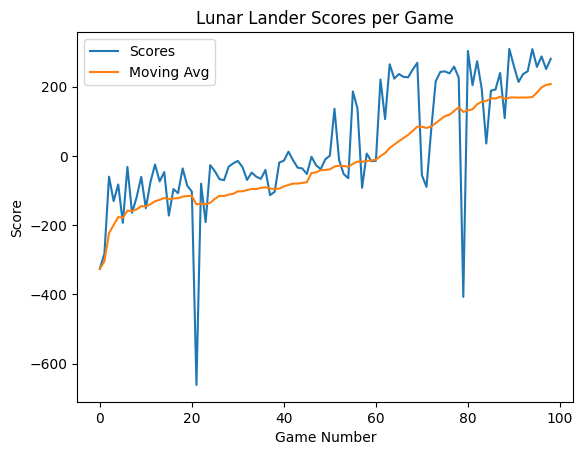

In [14]:
plt.plot(log["scores"], label="Scores")
plt.plot(log["running_avg_scores"], label="Moving Avg")
plt.title("Lunar Lander Scores per Game")
plt.xlabel("Game Number")
plt.ylabel("Score")
plt.legend()
plt.show()

### Lets Try a Game!

In [15]:
def record_game(env, agent, prefix, device="cuda"):

    env = gym.wrappers.RecordVideo(env, 
                                   video_folder="./savevideos", 
                                   video_length=0, 
                                   disable_logger=True,
                                   name_prefix=prefix)

    done = False
    state, _ = env.reset()
    
    while not done:

        ### Get Predicted Action ###
        action = agent.inference(torch.tensor(state).unsqueeze(0))

        ### Step in Environment ###
        new_state, reward, terminal, truncate, _ = env.step(action)
        done = terminal or truncate 
        
        ### State is our New State ###
        state = new_state
        
    env.close()
    
record_game(env, agent, prefix="dueling_q_learning_stable")

Video("savevideos/dueling_q_learning_stable-episode-0.mp4", embed=True)